# Autoencoder

In [1]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader
from autoencoder import Autoencoder_raw
from M0_0_util_train_test import load_model, train, test
from exp_version import get_hp_from_version_code
from util_model import parse_args, dcgan_config, resnext_config, log_cosh_loss


torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)

global_step = 0

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)


# Load data

In [53]:
# data loaders
zoomlevel = 'zoom15'
data_version = '1571'
sampling = 'stratified'
batch_size = 16
num_workers = 8
image_size = 224
im_norm = 1

train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, batch_size, 
         num_workers, 
         image_size, 
         data_version=data_version, 
         sampling=sampling, 
         recalculate_normalize=False,
         augment=False,
         norm=int(im_norm))

28278 images in dataset
3142 images in dataset


# 1. Load Existing Models

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")    

In [9]:
loss_func = 'mse'
latent_dim = '18432'
image_size = str(image_size)
model_run_date = '2208'

# model_path = glob.glob(model_dir+"Autoencoder/"+loss_func+"_"+zoomlevel+"_"+latent_dim+"_"+\
#                        str(image_size)+"_"+str(im_norm)+"_"+model_run_date+"_*.pt")
model_path = glob.glob(model_dir+"Autoencoder/"+loss_func+"_"+zoomlevel+"_"+latent_dim+"_"+\
                       str(im_norm)+"_"+model_run_date+"_*.pt")
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)


/dreambig/qingyi/image_chicago/models/Autoencoder/mse_zoom15_18432_1_2208_195.pt loaded.


In [12]:
config = saved['config']

encoder = config['encoder']
decoder = config['decoder']

model = load_model('autoencoder','Autoencoder_raw', config)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) + \
           sum([param.view(-1).size()[0] for param in decoder.parameters()])

print('n_params: {}'.format(n_params))

model_config = config['model_config']
run_config = config['run_config']
data_config = config['data_config']
optim_config = config['optim_config']

n_params: 31961862


In [13]:
model.load_state_dict(saved['model_state_dict']);

model = model.to(device)
model.eval();

# 2. Create New Model

In [15]:
model_run_date = '2302'
image_size = str(image_size)
color_channels = '3'
demo_channels = '0'
output_dim = '3'
latent_dim = '18432'
epochs = '200'
loss_func = 'cosh'
model_arch = 'resnext'
device = 'cuda:2'
base_lr = '0.001'
weight_decay = '0.0001'
im_norm = str(im_norm)

args = parse_args(s=['--model_run_date', model_run_date, '--zoomlevel', zoomlevel, '--image_size', image_size, 
                     '--color_channels', color_channels, '--demo_channels', demo_channels,
                     '--latent_dim', latent_dim, '--output_dim', output_dim,
                     '--epochs', epochs, '--loss_func', loss_func,
                     '--model_class', 'AE', '--model_arch', model_arch,
                     '--device', device, '--im_norm', im_norm, 
                     '--base_lr', base_lr, '--weight_decay', weight_decay])

device = torch.device(args.device if torch.cuda.is_available() else "cpu")    
writer = SummaryWriter(model_name) if args.tensorboard else None

In [16]:
if args.model_arch == 'dcgan':
        
    config = dcgan_config(args)
    encoder = load_model('dcgan', 'Discriminator', config)
    decoder = load_model('dcgan', 'Generator', config)
    
elif args.model_arch == 'resnext':

    config = resnext_config(args)
    encoder = load_model(config['model_config']['arch'], 'Encoder', config)
    decoder = load_model(config['model_config']['arch'], 'Decoder', config)

encoder = encoder.to(device)
decoder = decoder.to(device)

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('autoencoder','Autoencoder_raw', config)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) + \
       sum([param.view(-1).size()[0] for param in decoder.parameters()])

print('n_params: {}'.format(n_params))

n_params: 31961856


In [17]:
model_config = config['model_config']
run_config = config['run_config']
data_config = config['data_config']
optim_config = config['optim_config']

if args.loss_func == 'mse':
    criterion = nn.MSELoss(reduction='mean')
elif args.loss_func == 'cosh':
    criterion = log_cosh_loss
else:
    print("Loss func error!")

In [18]:
optimizer = torch.optim.Adam(
        model.parameters(),
        lr = optim_config['base_lr'],
        weight_decay = optim_config['weight_decay'],
        )

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

# Train model

[2023/02/18 17:17:48 __main__ INFO] - Train 0
[2023/02/18 17:22:06 __main__ INFO] - Epoch 0 Step 1767/1768 Train Loss 0.04584261
[2023/02/18 17:22:06 __main__ INFO] - Test 0
[2023/02/18 17:22:15 __main__ INFO] - Epoch 0 Test Loss 0.04313051
[2023/02/18 17:22:15 __main__ INFO] - Elapsed 9.42
[2023/02/18 17:22:15 __main__ INFO] - Test 0
[2023/02/18 17:22:26 __main__ INFO] - Epoch 0 Test Loss 0.04313051
[2023/02/18 17:22:26 __main__ INFO] - Elapsed 10.54
[2023/02/18 17:22:28 __main__ INFO] - Train 1
[2023/02/18 17:26:45 __main__ INFO] - Epoch 1 Step 1767/1768 Train Loss 0.04267852
[2023/02/18 17:26:45 __main__ INFO] - Test 1
[2023/02/18 17:26:54 __main__ INFO] - Epoch 1 Test Loss 0.04248844
[2023/02/18 17:26:54 __main__ INFO] - Elapsed 9.52
[2023/02/18 17:26:54 __main__ INFO] - Train 2
[2023/02/18 17:31:11 __main__ INFO] - Epoch 2 Step 1767/1768 Train Loss 0.04142285
[2023/02/18 17:31:11 __main__ INFO] - Test 2
[2023/02/18 17:31:20 __main__ INFO] - Epoch 2 Test Loss 0.04282079
[2023/02/18

[2023/02/18 19:14:56 __main__ INFO] - Epoch 25 Step 1767/1768 Train Loss 0.03694282
[2023/02/18 19:14:56 __main__ INFO] - Test 25
[2023/02/18 19:15:06 __main__ INFO] - Epoch 25 Test Loss 0.03743855
[2023/02/18 19:15:06 __main__ INFO] - Elapsed 9.43
[2023/02/18 19:15:06 __main__ INFO] - Test 25
[2023/02/18 19:15:17 __main__ INFO] - Epoch 25 Test Loss 0.03743855
[2023/02/18 19:15:17 __main__ INFO] - Elapsed 11.01
[2023/02/18 19:15:18 __main__ INFO] - Train 26
[2023/02/18 19:19:32 __main__ INFO] - Epoch 26 Step 1767/1768 Train Loss 0.03693618
[2023/02/18 19:19:32 __main__ INFO] - Test 26
[2023/02/18 19:19:42 __main__ INFO] - Epoch 26 Test Loss 0.03858623
[2023/02/18 19:19:42 __main__ INFO] - Elapsed 9.48
[2023/02/18 19:19:42 __main__ INFO] - Train 27
[2023/02/18 19:23:57 __main__ INFO] - Epoch 27 Step 1767/1768 Train Loss 0.03691249
[2023/02/18 19:23:57 __main__ INFO] - Test 27
[2023/02/18 19:24:06 __main__ INFO] - Epoch 27 Test Loss 0.03748959
[2023/02/18 19:24:06 __main__ INFO] - Elapse

[2023/02/18 21:05:57 __main__ INFO] - Epoch 50 Step 1767/1768 Train Loss 0.03632897
[2023/02/18 21:05:57 __main__ INFO] - Test 50
[2023/02/18 21:06:06 __main__ INFO] - Epoch 50 Test Loss 0.03714677
[2023/02/18 21:06:06 __main__ INFO] - Elapsed 9.44
[2023/02/18 21:06:06 __main__ INFO] - Test 50
[2023/02/18 21:06:17 __main__ INFO] - Epoch 50 Test Loss 0.03714677
[2023/02/18 21:06:17 __main__ INFO] - Elapsed 10.95
[2023/02/18 21:06:18 __main__ INFO] - Train 51
[2023/02/18 21:10:33 __main__ INFO] - Epoch 51 Step 1767/1768 Train Loss 0.03632061
[2023/02/18 21:10:33 __main__ INFO] - Test 51
[2023/02/18 21:10:42 __main__ INFO] - Epoch 51 Test Loss 0.03652131
[2023/02/18 21:10:42 __main__ INFO] - Elapsed 9.40
[2023/02/18 21:10:42 __main__ INFO] - Train 52
[2023/02/18 21:14:57 __main__ INFO] - Epoch 52 Step 1767/1768 Train Loss 0.03630571
[2023/02/18 21:14:57 __main__ INFO] - Test 52
[2023/02/18 21:15:06 __main__ INFO] - Epoch 52 Test Loss 0.03681532
[2023/02/18 21:15:06 __main__ INFO] - Elapse

[2023/02/18 22:56:56 __main__ INFO] - Epoch 75 Step 1767/1768 Train Loss 0.03607886
[2023/02/18 22:56:56 __main__ INFO] - Test 75
[2023/02/18 22:57:05 __main__ INFO] - Epoch 75 Test Loss 0.03614969
[2023/02/18 22:57:05 __main__ INFO] - Elapsed 9.47
[2023/02/18 22:57:05 __main__ INFO] - Test 75
[2023/02/18 22:57:16 __main__ INFO] - Epoch 75 Test Loss 0.03614969
[2023/02/18 22:57:16 __main__ INFO] - Elapsed 11.21
[2023/02/18 22:57:18 __main__ INFO] - Train 76
[2023/02/18 23:01:36 __main__ INFO] - Epoch 76 Step 1767/1768 Train Loss 0.03606720
[2023/02/18 23:01:36 __main__ INFO] - Test 76
[2023/02/18 23:01:46 __main__ INFO] - Epoch 76 Test Loss 0.03618146
[2023/02/18 23:01:46 __main__ INFO] - Elapsed 9.48
[2023/02/18 23:01:46 __main__ INFO] - Train 77
[2023/02/18 23:06:06 __main__ INFO] - Epoch 77 Step 1767/1768 Train Loss 0.03606243
[2023/02/18 23:06:06 __main__ INFO] - Test 77
[2023/02/18 23:06:16 __main__ INFO] - Epoch 77 Test Loss 0.03618487
[2023/02/18 23:06:16 __main__ INFO] - Elapse

[2023/02/19 00:50:58 __main__ INFO] - Epoch 100 Step 1767/1768 Train Loss 0.03597865
[2023/02/19 00:50:58 __main__ INFO] - Test 100
[2023/02/19 00:51:08 __main__ INFO] - Epoch 100 Test Loss 0.03604042
[2023/02/19 00:51:08 __main__ INFO] - Elapsed 9.53
[2023/02/19 00:51:08 __main__ INFO] - Test 100
[2023/02/19 00:51:19 __main__ INFO] - Epoch 100 Test Loss 0.03604042
[2023/02/19 00:51:19 __main__ INFO] - Elapsed 11.15
<ipython-input-21-91371a49e960>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(4,2))


Early stopping at epoch 100


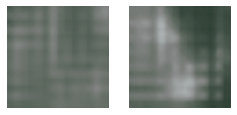

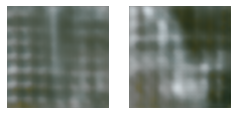

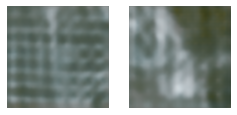

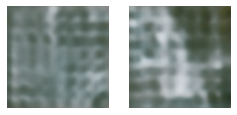

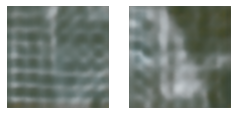

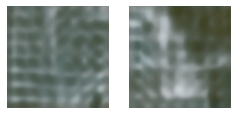

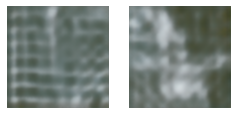

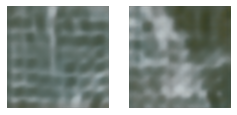

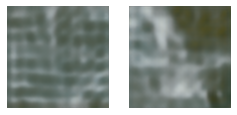

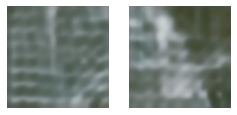

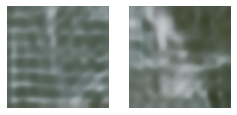

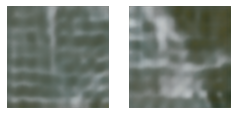

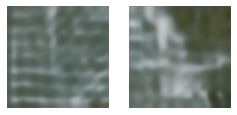

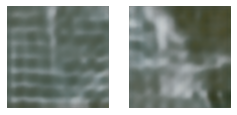

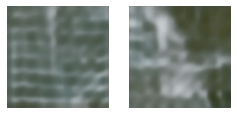

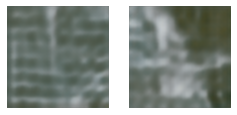

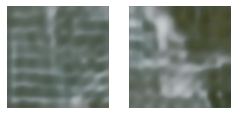

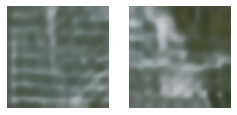

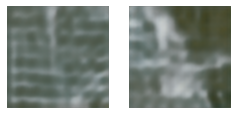

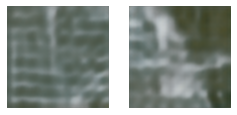

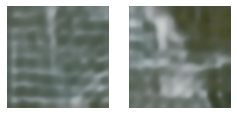

In [21]:
ref1 = 0
ref2 = 0

train_loss_list = []
test_loss_list = []

train_flag = True

for epoch in range(optim_config['epochs']):

    loss_ = train(epoch, model, optimizer, criterion, train_loader, run_config,
         writer, device, logger=logger)
    train_loss_list.append(loss_)

    scheduler.step()

    test_loss_ = test(epoch, model, criterion, test_loader, run_config,
                    writer, device, logger, return_output=False)
    test_loss_list.append(test_loss_)

    if epoch % 5 == 0:
        test_image_recon = test(epoch, model, criterion, test_loader, run_config, 
                                writer, device, logger, return_output=True)
        if args.im_norm != 0:

            if args.im_norm == 1:
                if args.zoomlevel == 'zoom13':
                    mean = [0.3733, 0.3991, 0.3711]
                    std = [0.2173, 0.2055, 0.2143]
                elif args.zoomlevel == 'zoom15':
                    mean = [0.3816, 0.4169, 0.3868]
                    std = [0.1960, 0.1848, 0.2052]

            elif args.im_norm == 2:
                mean = [0.5,0.5,0.5]
                std = [0.5,0.5,0.5]

            test_image_recon = util_image.inverse_transform(test_image_recon, mean, std)
            
        fig, ax = plt.subplots(1, 2, figsize=(4,2))
        ax[0].imshow(test_image_recon[0,:,:,:].permute(1,2,0).detach().cpu().numpy())
        ax[0].axis('off')
        ax[1].imshow(test_image_recon[9,:,:,:].permute(1,2,0).detach().cpu().numpy())
        ax[1].axis('off')
        fig.savefig(out_dir+'AE_Recon/'+str(epoch)+".png", bbox_inches='tight')    
        
        if epoch > 30:
            if (np.abs(loss_ - ref1)/ref1<0.001) & (np.abs(loss_ - ref2)/ref2<0.001):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                train_flag = False
                break
            if loss_ < best:
                best = loss_
                best_test = test_loss_
                best_epoch = epoch
        else:
            best = loss_
            best_test = test_loss_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': best,
                'test_loss': best_test,
                'config': config},
                model_dir+"Autoencoder/"+args.loss_func+"_"+args.zoomlevel+"_"+str(model_config['latent_dim'])+"_"+str(args.image_size)+"_"+str(int(args.im_norm))+"_"+str(args.model_run_date)+"_"+str(epoch)+".pt")

if config['run_config']['save']:
    files = glob.glob(model_dir+"Autoencoder/"+args.loss_func+"_"+args.zoomlevel+"_"+str(model_config['latent_dim'])+"_"+str(args.image_size)+"_"+str(int(args.im_norm))+"_"+str(args.model_run_date)+"_*.pt")    

    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)

            
with open(out_dir+"AE_tries.csv", "a") as f:
    f.write("%s,%s,%d,%d,%d,%.2E,%.2E,%d,%.4f,%.4f,%d,%s,%s\n" % 
            (args.model_run_date, args.zoomlevel, model_config['latent_dim'], args.image_size, 
             args.im_norm, args.base_lr, args.weight_decay, best_epoch, best, best_test, train_flag, 
             args.loss_func, args.model_arch))
    

## Reconstruction Results

In [108]:
for step, (image_list, data) in enumerate(test_loader):
    data = data.to(device)
    break
    
recon_imgs = model(data)

In [109]:
# Reverse Normalization
# Satellite image
import util_image

if int(im_norm) != 0:

    if int(im_norm) == 1:
        if zoomlevel == 'zoom13':
            mean = [0.3733, 0.3991, 0.3711]
            std = [0.2173, 0.2055, 0.2143]
        elif zoomlevel == 'zoom15':
            mean = [0.3816, 0.4169, 0.3868]
            std = [0.1960, 0.1848, 0.2052]

    elif int(im_norm) == 2:
        mean = [0.5,0.5,0.5]
        std = [0.5,0.5,0.5]

    data = util_image.inverse_transform(data, mean, std)
    recon_imgs = util_image.inverse_transform(recon_imgs, mean, std)

[2023/02/19 16:51:46 matplotlib.image WARNING] - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


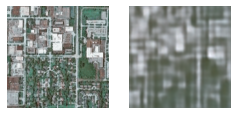

In [116]:
plot_image = 1
fig, ax = plt.subplots(1, 2, figsize=(4,2))
ax[0].imshow(data[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax[0].axis('off')
ax[1].imshow(recon_imgs[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax[1].axis('off')
plt.show()

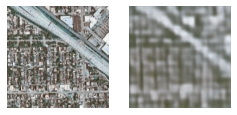

In [126]:
plot_image = 15
fig, ax = plt.subplots(1, 2, figsize=(4,2))
ax[0].imshow(data[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax[0].axis('off')
ax[1].imshow(recon_imgs[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax[1].axis('off')
plt.show()